# Evaluate and Compare Whisper Models on Tajik Holdout Set

This notebook evaluates your fine-tuned Whisper model and compares it with Whisper Small, Medium, and Large on a Tajik holdout set.

In [ ]:
# Install dependencies
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets[audio] transformers accelerate evaluate jiwer matplotlib pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 99.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 107.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 64.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Holdout Data

In [2]:
import json
from pathlib import Path
from datasets import Dataset, Audio

holdout_metadata_path = '/content/drive/MyDrive/dataset/holdout/metadata.jsonl'
audio_base_path = '/content/drive/MyDrive/dataset/holdout/audio'

with open(holdout_metadata_path, 'r', encoding='utf-8') as f:
    data = [json.loads(line) for line in f]

for item in data:
    # Update audio path to absolute for Colab
    item['audio'] = str(Path(audio_base_path) / Path(item['audio_path']).name)
    item['sentence'] = item['text'].strip()
    del item['audio_path']
    del item['text']
    if 'duration' in item: del item['duration']

holdout_dataset = Dataset.from_list(data)
holdout_dataset = holdout_dataset.cast_column('audio', Audio(sampling_rate=16000))
holdout_dataset = holdout_dataset.remove_columns([col for col in holdout_dataset.column_names if col not in ['audio', 'sentence']])
print(holdout_dataset[0])

{'audio': {'path': '/content/drive/MyDrive/dataset/holdout/audio/human_recording_000000.wav', 'array': array([ 1.19887738e-06, -1.68267775e-06,  2.06628829e-06, ...,
        5.89881465e-03,  7.16168620e-03,  0.00000000e+00]), 'sampling_rate': 16000}, 'sentence': 'ин коро имсол онхо худашон ичро менамоянд'}


## Prepare Feature Extractor and Tokenizer

In [19]:
from transformers import WhisperProcessor

# Use Tajik language and transcribe task
processor_small = WhisperProcessor.from_pretrained('openai/whisper-small', language='Tajik', task='transcribe')
processor_medium = WhisperProcessor.from_pretrained('openai/whisper-medium', language='Tajik', task='transcribe')
processor_large = WhisperProcessor.from_pretrained('openai/whisper-large', language='Tajik', task='transcribe')
processor_finetuned = WhisperProcessor.from_pretrained('/content/drive/MyDrive/whisper-small-tg')

## Prepare Input Features for Evaluation

In [20]:
def prepare_features(batch, processor):
    audio = batch['audio']
    batch['input_features'] = processor.feature_extractor(audio['array'], sampling_rate=audio['sampling_rate']).input_features[0]
    batch['labels'] = processor.tokenizer(batch['sentence']).input_ids
    return batch

# Prepare for each processor (they share the same audio, so one is enough)
eval_dataset = holdout_dataset.map(lambda x: prepare_features(x, processor_small))
print(eval_dataset[0])

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

{'audio': {'path': None, 'array': array([ 0.00000000e+00, -3.05175781e-05,  0.00000000e+00, ...,
        5.88989258e-03,  7.14111328e-03,  0.00000000e+00]), 'sampling_rate': 16000}, 'sentence': 'ин коро имсол онхо худашон ичро менамоянд', 'input_features': [[-0.9835370779037476, 0.1300867199897766, 0.22472965717315674, 0.2490730881690979, 0.290480375289917, 0.25191378593444824, 0.26906025409698486, 0.31284940242767334, 0.28072619438171387, 0.30825310945510864, 0.32846564054489136, 0.32638633251190186, 0.3191513419151306, 0.27153444290161133, 0.2505548596382141, 0.18899619579315186, 0.2634599208831787, 0.270083487033844, 0.22863078117370605, 0.23895412683486938, 0.24415630102157593, 0.28533029556274414, 0.2964860796928406, 0.3311975598335266, 0.35533779859542847, 0.34172242879867554, 0.3344535827636719, 0.2862851023674011, 0.2664712071418762, 0.2743685841560364, 0.2798318862915039, 0.287514328956604, 0.3049573302268982, 0.2411852478981018, 0.24958282709121704, 0.3009856343269348, 0.2933

## Define Evaluation Function

In [21]:
import torch
from transformers import WhisperForConditionalGeneration

def evaluate_model(model_name_or_path, processor, dataset, language="tg", task="transcribe"):
    model = WhisperForConditionalGeneration.from_pretrained(model_name_or_path).to('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    predictions = []
    references = []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    forced_decoder_ids = processor.tokenizer.get_decoder_prompt_ids(language=language, task=task)
    for sample in dataset:
        inputs = processor.feature_extractor.pad([{'input_features': sample['input_features']}], return_tensors='pt').to(device)
        with torch.no_grad():
            generated_ids = model.generate(
                inputs.input_features,
                max_length=225,
                forced_decoder_ids=forced_decoder_ids
            )
        pred = processor.tokenizer.batch_decode(generated_ids, skip_special_tokens=True)[0]
        predictions.append(pred)
        label_ids = sample['labels']
        label_ids = [processor.tokenizer.pad_token_id if id == -100 else id for id in label_ids]
        ref = processor.tokenizer.decode(label_ids, skip_special_tokens=True)
        references.append(ref)
    return predictions, references

## Evaluate All Models

In [22]:
# Fine-tuned
pred_finetuned, refs = evaluate_model(
    '/content/drive/MyDrive/whisper-small-tg/checkpoint-4000',
    processor_finetuned,
    eval_dataset
)
# Whisper Small
pred_small, _ = evaluate_model('openai/whisper-small', processor_small, eval_dataset)
# Whisper Medium
pred_medium, _ = evaluate_model('openai/whisper-medium', processor_medium, eval_dataset)
# Whisper Large
pred_large, _ = evaluate_model('openai/whisper-large', processor_large, eval_dataset)

You have passed task=transcribe, but also have set `forced_decoder_ids` to [(1, 50331), (2, 50359), (3, 50363)] which creates a conflict. `forced_decoder_ids` will be ignored in favor of task=transcribe.


## Compute WER and CER

In [10]:
!pip install evaluate
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 38.9 MB/s eta 0:00:00


In [45]:
import re

def normalize(texts):
    normalized = []
    for text in texts:
        # Lowercase
        text = text.lower()
        # Remove special characters (keep letters, numbers, spaces)
        text = re.sub(r'[^a-zA-Z0-9а-яёӣқғҳҷӯүҳӣӄӌӟӱӳ\s]', '', text)
        # Remove extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        normalized.append(text)
    return normalized


pred_finetuned = normalize(pred_finetuned)
pred_small = normalize(pred_small)
pred_medium = normalize(pred_medium)
pred_large = normalize(pred_large)
refs = normalize(refs)

In [46]:
import evaluate

wer_metric = evaluate.load('wer')
cer_metric = evaluate.load('cer')

results = {
    'Finetuned': {
        'WER': 100 * wer_metric.compute(predictions=pred_finetuned, references=refs),
        'CER': 100 * cer_metric.compute(predictions=pred_finetuned, references=refs),
    },
    'Whisper-Small': {
        'WER': 100 * wer_metric.compute(predictions=pred_small, references=refs),
        'CER': 100 * cer_metric.compute(predictions=pred_small, references=refs),
    },
    'Whisper-Medium': {
        'WER': 100 * wer_metric.compute(predictions=pred_medium, references=refs),
        'CER': 100 * cer_metric.compute(predictions=pred_medium, references=refs),
    },
    'Whisper-Large': {
        'WER': 100 * wer_metric.compute(predictions=pred_large, references=refs),
        'CER': 100 * cer_metric.compute(predictions=pred_large, references=refs),
    }
}
results

{'Finetuned': {'WER': 55.44993662864385, 'CER': 26.861004639903168},
 'Whisper-Small': {'WER': 101.45754119138151, 'CER': 44.52289691345572},
 'Whisper-Medium': {'WER': 95.56400506970849, 'CER': 40.407504539035706},
 'Whisper-Large': {'WER': 94.23320659062104, 'CER': 43.2317934234416}}

## Visualize Results

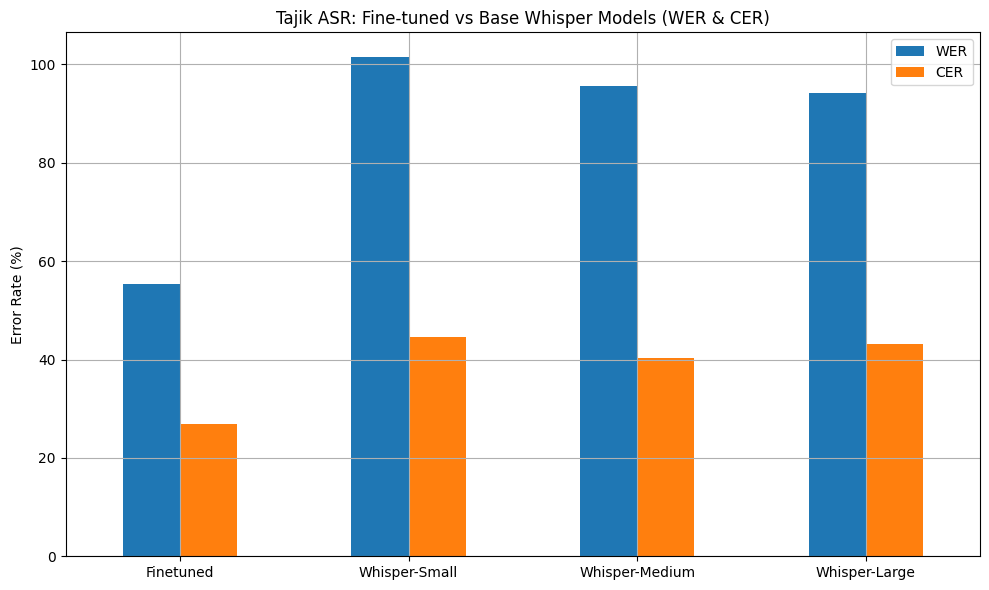

In [47]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results).T
df.plot(kind='bar', figsize=(10, 6), rot=0)
plt.ylabel('Error Rate (%)')
plt.title('Tajik ASR: Fine-tuned vs Base Whisper Models (WER & CER)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [48]:
pred_finetuned_male = pred_finetuned[:50]
refs_male = refs[:50]

pred_finetuned_female = pred_finetuned[50:]
refs_female = refs[50:]

pred_medium_male = pred_medium[:50]
refs_medium_male = refs[:50]

pred_medium_female = pred_medium[50:]
refs_medium_female = refs[50:]

pred_small_male = pred_small[:50]
refs_small_male = refs[:50]

pred_small_female = pred_small[50:]
refs_small_female = refs[50:]

pred_large_male = pred_large[:50]
refs_large_male = refs[:50]

pred_large_female = pred_large[50:]
refs_large_female = refs[50:]

In [49]:
results_gender = {
    'Finetuned': {
        'WER_Male': 100 * wer_metric.compute(predictions=pred_finetuned_male, references=refs_male),
        'CER_Male': 100 * cer_metric.compute(predictions=pred_finetuned_male, references=refs_male),
        'WER_Female': 100 * wer_metric.compute(predictions=pred_finetuned_female, references=refs_female),
        'CER_Female': 100 * cer_metric.compute(predictions=pred_finetuned_female, references=refs_female),
    },
    'Whisper-Small': {
        'WER_Male': 100 * wer_metric.compute(predictions=pred_small_male, references=refs_male),
        'CER_Male': 100 * cer_metric.compute(predictions=pred_small_male, references=refs_male),
        'WER_Female': 100 * wer_metric.compute(predictions=pred_small_female, references=refs_female),
        'CER_Female': 100 * cer_metric.compute(predictions=pred_small_female, references=refs_female),
    },
    'Whisper-Medium': {
        'WER_Male': 100 * wer_metric.compute(predictions=pred_medium_male, references=refs_male),
        'CER_Male': 100 * cer_metric.compute(predictions=pred_medium_male, references=refs_male),
        'WER_Female': 100 * wer_metric.compute(predictions=pred_medium_female, references=refs_female),
        'CER_Female': 100 * cer_metric.compute(predictions=pred_medium_female, references=refs_female),
    },
    'Whisper-Large': {
        'WER_Male': 100 * wer_metric.compute(predictions=pred_large_male, references=refs_male),
        'CER_Male': 100 * cer_metric.compute(predictions=pred_large_male, references=refs_male),
        'WER_Female': 100 * wer_metric.compute(predictions=pred_large_female, references=refs_female),
        'CER_Female': 100 * cer_metric.compute(predictions=pred_large_female, references=refs_female),
    }
}

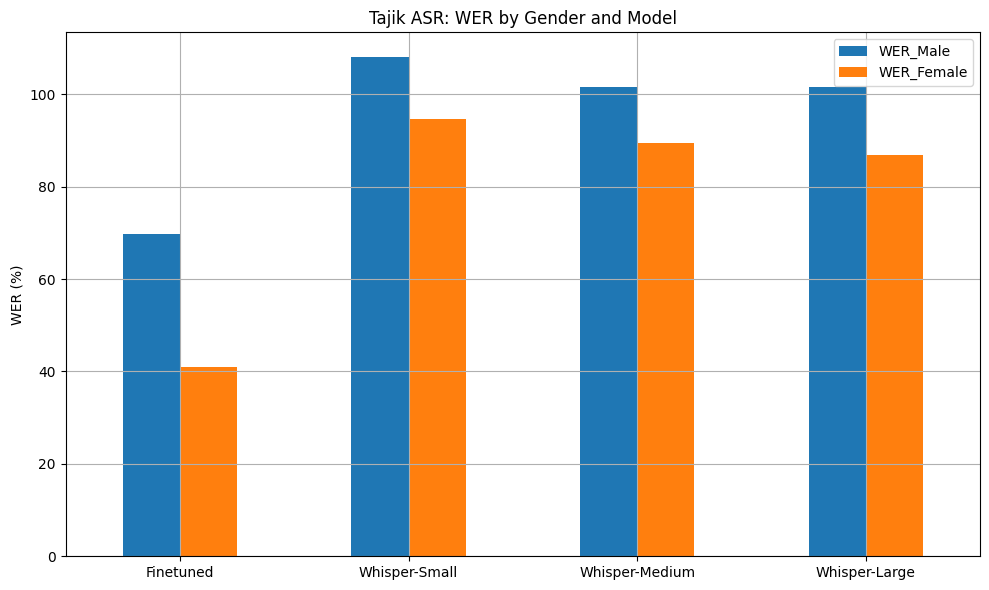

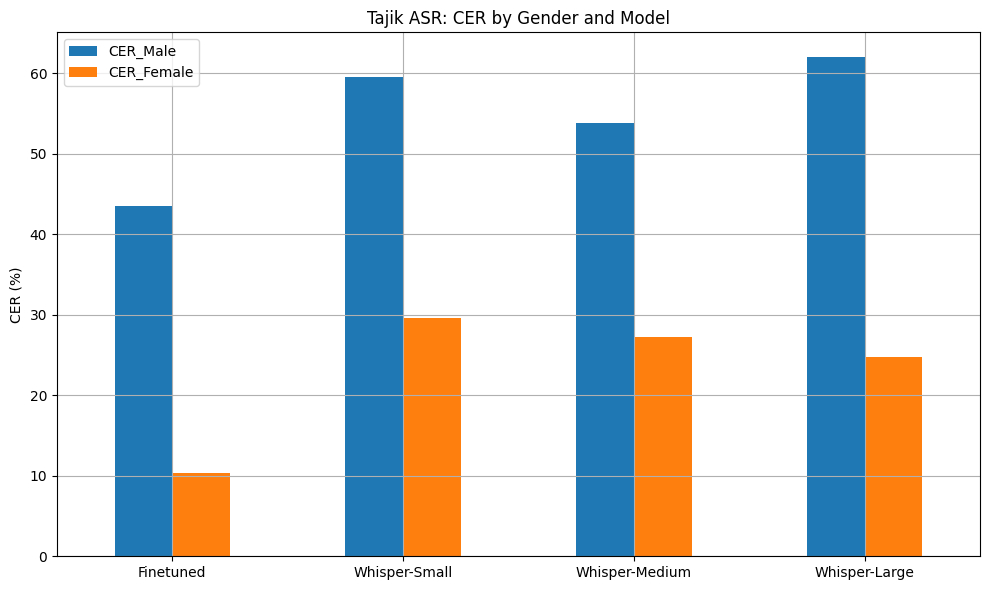

In [50]:
df_gender = pd.DataFrame(results_gender).T

# Plot WER for Male vs Female
df_gender[['WER_Male', 'WER_Female']].plot(kind='bar', figsize=(10, 6), rot=0)
plt.ylabel('WER (%)')
plt.title('Tajik ASR: WER by Gender and Model')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot CER for Male vs Female
df_gender[['CER_Male', 'CER_Female']].plot(kind='bar', figsize=(10, 6), rot=0)
plt.ylabel('CER (%)')
plt.title('Tajik ASR: CER by Gender and Model')
plt.grid(True)
plt.tight_layout()
plt.show()

In [51]:
for i in range(5):
    print(f"REF: {refs[i]}")
    print(f"PRED: {pred_small[i]}")
    print()

REF: ин коро имсол онхо худашон ичро менамоянд
PRED: ин карат им сол анахудашан ж раме нема ант

REF: ана ҳамин тоҷикписар дар ҷӯшу хурӯши ҷанг коре кардааст бебаҳо раҳмон сафар ман истода ба чашмонам дида медӯзад
PRED: эне хемин тоджик бисар дар жошу хороши джанк карекарда сбей баху орахман сафар ман исто даба чашмоном диде мейдозат

REF: бекорӣ дар ҳавзаи евро ба ҳадди рекордӣ расид бекорӣ дар кишвари ҳавзаи евро ба ҳадде расидааст ки то кунун мушоҳида нашуда буд
PRED: бекари дар хавзе евра бахади рекорди ресид бекари дар кишвери хавзе евра бахаде ресид аз ки та қанун мошаида нешуда бут

REF: аз пашша фил сози хуб нест
PRED: аспаш шефиль соз и хубнест

REF: чунин баъдтар дар нимаи дувв асри ва ибтидои асри дар зери таъсири матлуби илм ва фарҳанги ҷаҳонӣ дар шаҳрҳои тошканду самарқанд бухоро пайдо шуданд
PRED: чунин баттар дар дима едув асре иптидай асре дар зери таасри матлоби ил ба фарханги дажаа дар шағархуе тошканд и смарканд бухуууууууууууууууууууууууууууууууууууууууууууууууууууу

In [52]:
for i in range(5):
    print(f"REF: {refs[i]}")
    print(f"PRED: {pred_finetuned[i]}")
    print()

REF: ин коро имсол онхо худашон ичро менамоянд
PRED: ин кор мақим сол у онҳо худашон иҷро менамоянд

REF: ана ҳамин тоҷикписар дар ҷӯшу хурӯши ҷанг коре кардааст бебаҳо раҳмон сафар ман истода ба чашмонам дида медӯзад
PRED: ана ҳамин тоҷик писар дар ҷӯшу ҳӯрӯши ҷанг кора кардааст бе баҳор аҳмон сафар ман истода ба чашмонам дидя медӯзат

REF: бекорӣ дар ҳавзаи евро ба ҳадди рекордӣ расид бекорӣ дар кишвари ҳавзаи евро ба ҳадде расидааст ки то кунун мушоҳида нашуда буд
PRED: бекорӣ дар ҳавзаи евра ба хатти рекордӣ расид бекорӣ дар кишвари ҳавзаи евра ба хатта расидааст ки то қонун муҳои мушоҳида нашуда буд

REF: аз пашша фил сози хуб нест
PRED: аз пашша филсози хуб нест

REF: чунин баъдтар дар нимаи дувв асри ва ибтидои асри дар зери таъсири матлуби илм ва фарҳанги ҷаҳонӣ дар шаҳрҳои тошканду самарқанд бухоро пайдо шуданд
PRED: чунин бадтар дар дин майи дув асри ва ибтидои асри дар зери таъсири матлубии илм ва фарҳанги ҷаҳонӣ дар шаҳраҳои тошканду самарқанд бухоро пайдо шуданд



In [53]:
results

{'Finetuned': {'WER': 55.44993662864385, 'CER': 26.861004639903168},
 'Whisper-Small': {'WER': 101.45754119138151, 'CER': 44.52289691345572},
 'Whisper-Medium': {'WER': 95.56400506970849, 'CER': 40.407504539035706},
 'Whisper-Large': {'WER': 94.23320659062104, 'CER': 43.2317934234416}}

In [54]:
results_gender

{'Finetuned': {'WER_Male': 69.67418546365914,
  'CER_Male': 43.59130611415804,
  'WER_Female': 40.8974358974359,
  'CER_Female': 10.35864556201162},
 'Whisper-Small': {'WER_Male': 108.02005012531328,
  'CER_Male': 59.597806215722116,
  'WER_Female': 94.74358974358974,
  'CER_Female': 29.653376076938486},
 'Whisper-Medium': {'WER_Male': 101.62907268170427,
  'CER_Male': 53.78834044281942,
  'WER_Female': 89.35897435897436,
  'CER_Female': 27.20897615708275},
 'Whisper-Large': {'WER_Male': 101.50375939849626,
  'CER_Male': 62.01503148486695,
  'WER_Female': 86.7948717948718,
  'CER_Female': 24.704468042476456}}